# Image Segmentation

In [ ]:
# !pip install transformers
# !pip install timm
# !pip install torchvision

In [2]:
from transformers.utils import logging
logging.set_verbosity_error()

from transformers import pipeline

Lets try segmentation by masking (Segment Anything Model). We will use **SlimSAM-uniform-77**.
Unlike usual image segmentation, he we guide the model on which object specifically to be segemented out (py passing object pixel location or bounding box on image). This does not output the class of mask.

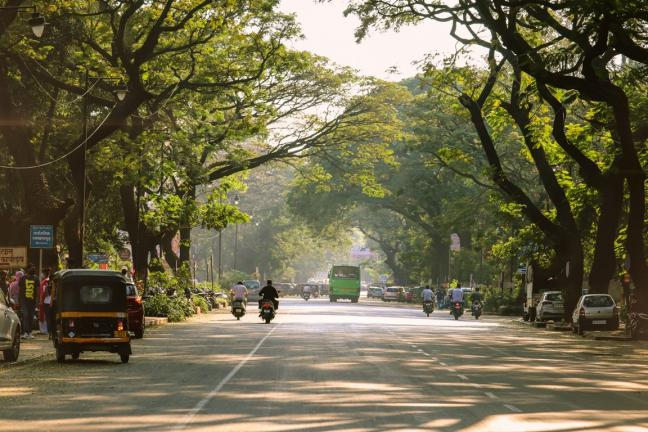

In [21]:
raw_image = Image.open('green.jpg')
raw_image

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3),
                                np.array([0.6])],
                               axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_pipe_masks_on_image(raw_image, outputs):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  for mask in outputs["masks"]:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()

def show_mask_on_image(raw_image, mask, return_image=False):
    if not isinstance(mask, torch.Tensor):
      mask = torch.Tensor(mask)

    if len(mask.shape) == 4:
      mask = mask.squeeze()

    fig, axes = plt.subplots(1, 1, figsize=(15, 15))

    mask = mask.cpu().detach()
    axes.imshow(np.array(raw_image))
    show_mask(mask, axes)
    axes.axis("off")
    plt.show()

    if return_image:
      fig = plt.gcf()
      return fig2img(fig)

In [38]:
#Faster Inference
from transformers import SamModel, SamProcessor

model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")
processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

# Point on object to be segmented
input_points = [[[500, 700]]]

inputs = processor(
  raw_image,
  input_points=input_points,
  return_tensors="pt"
)

import torch
with torch.no_grad():
    outputs = model(**inputs)

predicted_masks = processor.image_processor.post_process_masks(
  outputs.pred_masks,
  inputs["original_sizes"],
  inputs["reshaped_input_sizes"]
)

In [40]:
predicted_mask = predicted_masks[0]
outputs.iou_scores

tensor([[[0.9488, 0.9654, 0.3679]]])

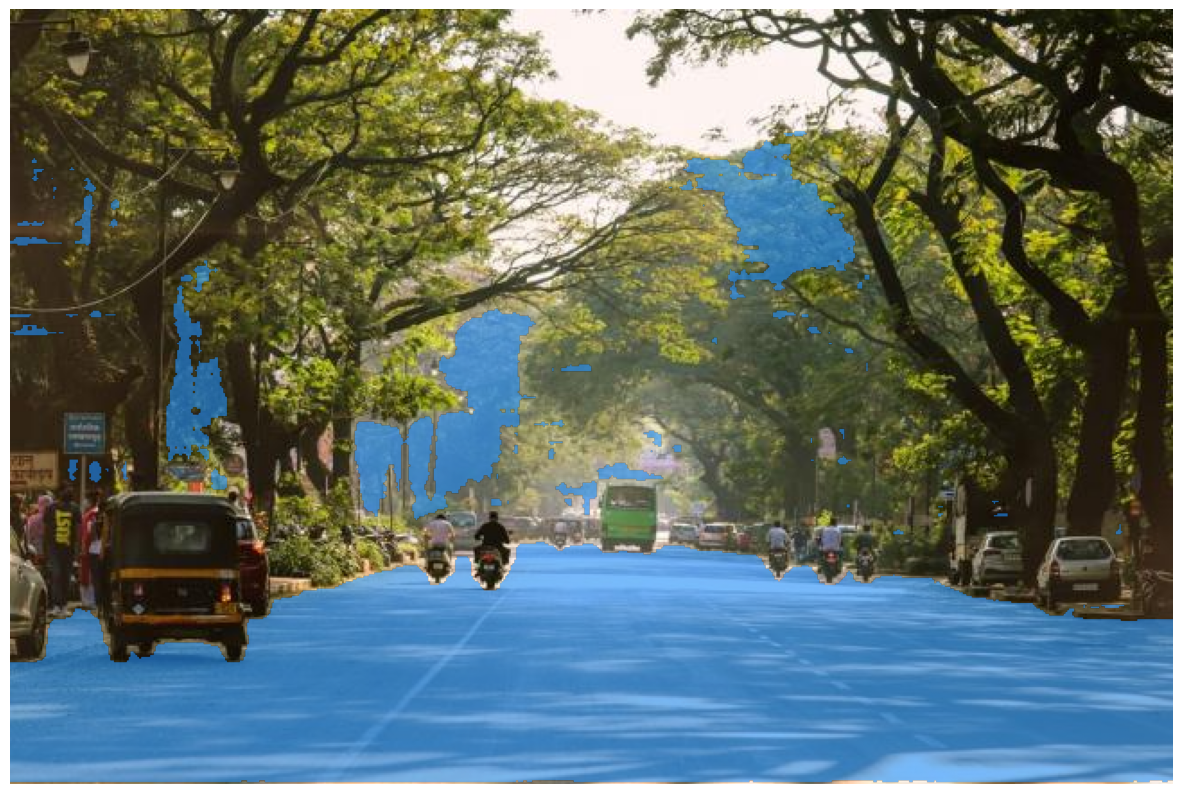

In [58]:
for i in range(1):
    show_mask_on_image(raw_image, predicted_mask[:, i])

Lets try **Depth Estimation** using Intel's dpt-hybrid-midas

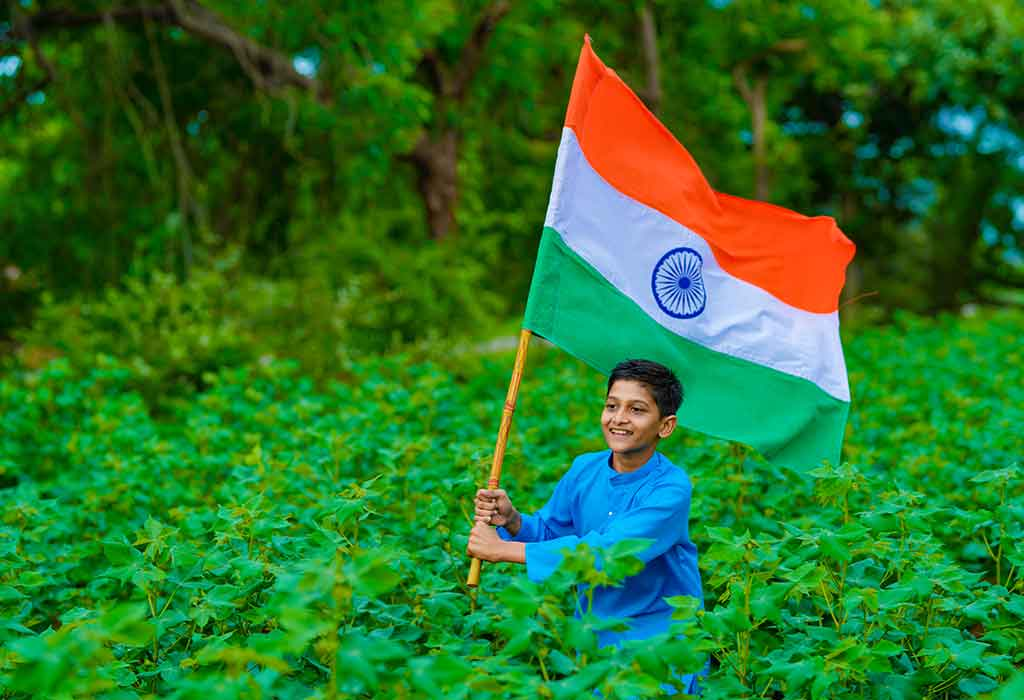

In [68]:
# creating pipeline
depth_estimator = pipeline(task="depth-estimation", model="Intel/dpt-hybrid-midas")

# loading image
raw_image = Image.open('india.jpg')
display(raw_image)

# inference
output = depth_estimator(raw_image)

prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

Predicted Depths : 


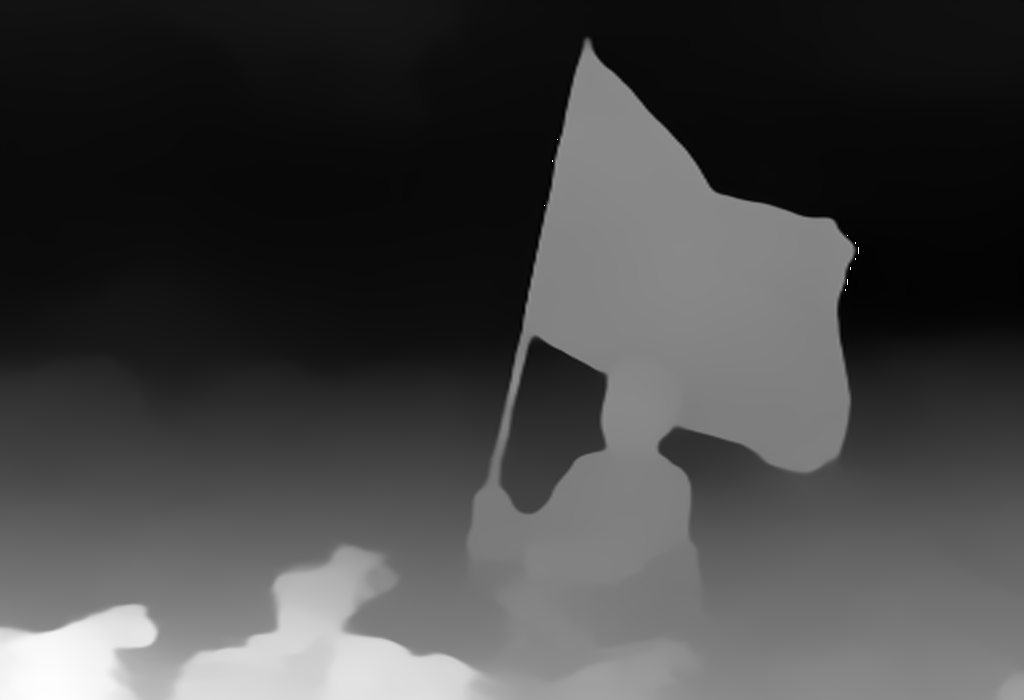

In [69]:
print("Predicted Depths : ")
depth